Do bats perceive rats not just as competitors for food but also as potential predators?

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df1 = pd.read_csv("dataset1.csv", parse_dates=["start_time","rat_period_start","rat_period_end"])
df2 = pd.read_csv("dataset2.csv", parse_dates=["time"])

In [3]:
print("DF1", df1.shape)
print("DF2", df2.shape)

DF1 (907, 12)
DF2 (2123, 7)


In [4]:
for col in ["bat_landing_to_food","seconds_after_rat_arrival","hours_after_sunset","reward","risk"]:
    if col in df1.columns:
        df1[col] = pd.to_numeric(df1[col], errors="coerce")

for col in ["rat_arrival_number","rat_minutes","bat_landing_number","food_availability","hours_after_sunset"]:
    if col in df2.columns:
        df2[col] = pd.to_numeric(df2[col], errors="coerce")

In [5]:
df1["rat_present_at_landing"] = ((df1["start_time"] >= df1["rat_period_start"]) & (df1["start_time"] <= df1["rat_period_end"])).astype(int)

In [7]:
print("\nrat_present_at_landing counts:")
df1["rat_present_at_landing"].value_counts()


rat_present_at_landing counts:


rat_present_at_landing
1    907
Name: count, dtype: int64

In [8]:
df2 = df2.sort_values("time").copy()
df2["period_start"] = df2["time"]
df2["period_end"] = df2["time"] + pd.Timedelta(minutes=30)

In [9]:
def find_period_start(ts, periods=df2[["period_start","period_end"]]):
    match = periods[(periods["period_start"] <= ts) & (ts < periods["period_end"])]
    return match.iloc[0]["period_start"] if not match.empty else pd.NaT

In [10]:
df1["period_start"] = df1["start_time"].apply(find_period_start)
df = df1.merge(df2, on="period_start", how="left", suffixes=("","_period"))

In [11]:
df["rat_minutes"] = df["rat_minutes"].fillna(0)
nonzero = df.loc[df["rat_minutes"]>0, "rat_minutes"]
if len(nonzero) >= 5:
    q = nonzero.quantile([0.33,0.66]).values
    def rat_group(v):
        if v==0: return "none"
        if v <= q[0]: return "low"
        if v <= q[1]: return "medium"
        return "high"
    df["rat_activity_group"] = df["rat_minutes"].apply(rat_group)
else:
    df["rat_activity_group"] = df["rat_minutes"].apply(lambda v: "none" if v==0 else "some")

In [12]:
df["rat_activity_group"].value_counts()

rat_activity_group
high      309
low       301
medium    297
Name: count, dtype: int64

Descriptive statistics

In [13]:
print("\nOverview:")
print({
    "n_landings": len(df),
    "n_periods": len(df2),
    "total_rat_minutes": df["rat_minutes"].sum(),
    "total_rat_arrivals": df2["rat_arrival_number"].sum()
})


Overview:
{'n_landings': 907, 'n_periods': 2123, 'total_rat_minutes': np.float64(9257.683333322), 'total_rat_arrivals': np.int64(944)}


In [14]:
print("\nRisk by rat activity group:")
risk_tab = df.groupby("rat_activity_group")["risk"].agg(["count","sum","mean"]).rename(columns={"sum":"n_risk","mean":"risk_rate"})
print(risk_tab)


Risk by rat activity group:
                    count  n_risk  risk_rate
rat_activity_group                          
high                  309     155   0.501618
low                   301     162   0.538206
medium                297     132   0.444444


In [16]:
print("\nHesitation (bat_landing_to_food) by rat activity group:")
hes_tab = df.groupby("rat_activity_group")["bat_landing_to_food"].describe()
hes_tab


Hesitation (bat_landing_to_food) by rat activity group:


,count,mean,std,min,25%,50%,75%,max
rat_activity_group,,,,,,,,
high,309.0,15.325050,37.004313,0.010871,1.0,4.0,14.0,443.0
low,301.0,9.299052,17.914143,0.014004,1.0,4.0,10.0,174.0
medium,297.0,10.401876,23.827650,0.010238,1.0,4.0,11.0,237.0


Inferential tests

In [17]:
tests = {}

# Risk-taking: z-test (any rat vs none)
any_rat = df["rat_minutes"] > 0
counts = np.array([df.loc[any_rat, "risk"].sum(), df.loc[~any_rat, "risk"].sum()])
nobs   = np.array([any_rat.sum(), (~any_rat).sum()])
if nobs.min() > 0:
    z, p = proportions_ztest(count=counts, nobs=nobs)
    tests["risk_anyrat_ztest"] = {"z": z, "p": p}

In [18]:
# Hesitation: t-test + Mann-Whitney
none_group = df.loc[df["rat_minutes"]==0, "bat_landing_to_food"].dropna()
some_group = df.loc[df["rat_minutes"]>0, "bat_landing_to_food"].dropna()
if len(none_group)>1 and len(some_group)>1:
    t_stat, t_p = stats.ttest_ind(none_group, some_group, equal_var=False)
    u_stat, u_p = stats.mannwhitneyu(none_group, some_group, alternative="two-sided")
    tests["hesitation_ttest"] = {"t": t_stat, "p": t_p}
    tests["hesitation_mannwhitney"] = {"U": u_stat, "p": u_p}

In [19]:
tests["correlations"] = {
    "rat_arrival_vs_batlandings": df2["rat_arrival_number"].corr(df2["bat_landing_number"]),
    "rat_minutes_vs_batlandings": df2["rat_minutes"].corr(df2["bat_landing_number"])
}

In [20]:
print("\nInferential test results:")
tests


Inferential test results:


{'correlations': {'rat_arrival_vs_batlandings': np.float64(-0.07353632546043416),
  'rat_minutes_vs_batlandings': np.float64(-0.14622750084478836)}}

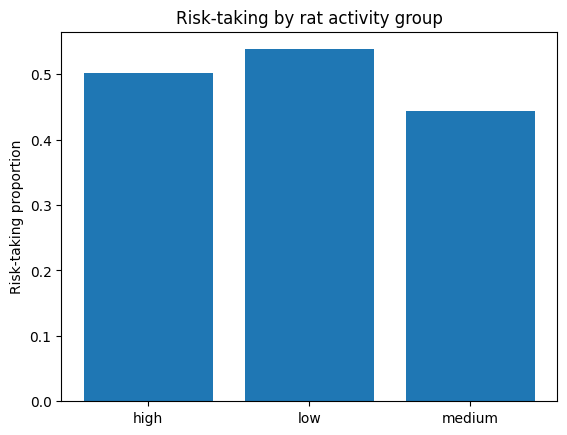

In [21]:
if "risk" in df.columns:
    grp = df.groupby("rat_activity_group")["risk"].mean()
    plt.bar(grp.index, grp.values)
    plt.ylabel("Risk-taking proportion")
    plt.title("Risk-taking by rat activity group")
    plt.show()

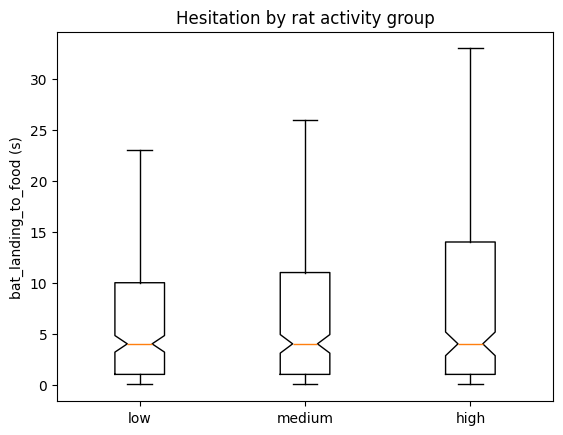

In [22]:
if "bat_landing_to_food" in df.columns:
    groups = [df.loc[df["rat_activity_group"]==g, "bat_landing_to_food"].dropna() for g in df["rat_activity_group"].unique()]
    labels = [str(g) for g in df["rat_activity_group"].unique()]
    plt.boxplot(groups, labels=labels, notch=True, showfliers=False)
    plt.ylabel("bat_landing_to_food (s)")
    plt.title("Hesitation by rat activity group")
    plt.show()

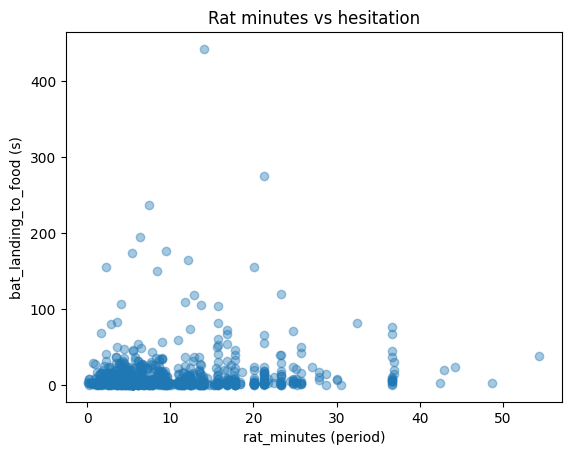

In [23]:
if "bat_landing_to_food" in df.columns:
    plt.scatter(df["rat_minutes"], df["bat_landing_to_food"], alpha=0.4)
    plt.xlabel("rat_minutes (period)")
    plt.ylabel("bat_landing_to_food (s)")
    plt.title("Rat minutes vs hesitation")
    plt.show()

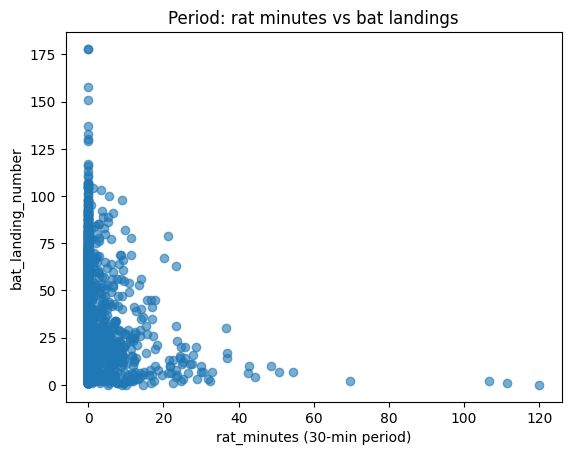

In [24]:
if "rat_minutes" in df2.columns and "bat_landing_number" in df2.columns:
    plt.scatter(df2["rat_minutes"], df2["bat_landing_number"], alpha=0.6)
    plt.xlabel("rat_minutes (30-min period)")
    plt.ylabel("bat_landing_number")
    plt.title("Period: rat minutes vs bat landings")
    plt.show()